The goal of this analysis will be to predict diamond prices in usd using various regression techniques.
I will use the cliche Kaggle diamond dataset: https://www.kaggle.com/datasets/shivam2503/diamonds.
However, this will be a fresh analysis and not a copy of any tutorial or other published notebook.


I started by getting the set into a DataFrame and checking for duplicate IDs.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

path_to_csv = 'diamonds.csv'

df = pd.read_csv(path_to_csv)
print(df.head())

df = df.rename(columns={'Unnamed: 0': 'id'})
if df['id'].is_unique:
  print('no duplicates found')

print(df.head())

   Unnamed: 0  carat      cut color clarity  depth  table  price     x     y  \
0           1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98   
1           2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84   
2           3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07   
3           4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23   
4           5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35   

      z  
0  2.43  
1  2.31  
2  2.31  
3  2.63  
4  2.75  
no duplicates found
   id  carat      cut color clarity  depth  table  price     x     y     z
0   1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   5   0.31     Good     J     SI2   63.3   58.0    335  4.34  

I then checked each column for nulls and found none.  Given that regression techniques usually require numerical data, the 3 categorical columns also needed special handling.  I started this by eyeballing the distribution of values in those columns and found nothing that would raise any flags here.  The distributions were hardly uniform, but each value for each variable had at least 500 observations, which applies the law of large numbers

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64


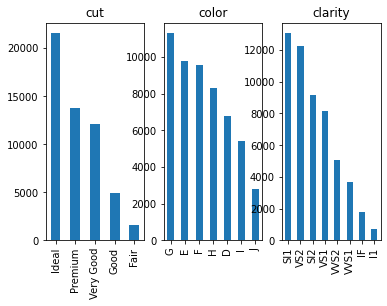

In [24]:
print(df.isna().sum())
categorical_columns = ['cut','color','clarity']

for column in categorical_columns:
  print(df[column].value_counts())

fig, ax = plt.subplots(1, len(categorical_columns))
for i, column in enumerate(df[categorical_columns]):
  df[column].value_counts().plot(kind='bar', ax=ax[i]).set_title(column)
  
fig.show()


As color and clarity are ordinal features, applying plain integer encoding is appropriate.  Cut is also ordinal by nature, but I can't determine whether premium or ideal is the most valuable cut.  Fair < Good < Very Good is clear from the [GIA](https://www.gia.edu/doc/estimating_cut_grade_chart_lowres.pdf), but premium and ideal are not included in the scale.  Excellent from the GIA's scale is not included in the dataset.  Cut will have to be treated as nominal.  First, integer encoding for the ordinal color and clarity.

In [34]:
working_df = df.copy()
working_df['color'] = working_df['color'].replace(['J','I','H','G','F','E','D'],
                                          [0,1,2,3,4,5,6])
working_df['clarity']= working_df['clarity'].replace(['I1','SI2','SI1','VS2',
                                              'VS1','VVS2','VVS1','IF'],
                                             [0,1,2,3,4,5,6,7])
working_df.head()


,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,5,1,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,5,2,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,5,4,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,1,3,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,0,1,63.3,58.0,335,4.34,4.35,2.75


This does rely on the assumption that the difference in price between each of the levels in color and clarity are equal. This is likely not true, but I will come back and explore this later in the analysis.  Next comes a test for multi-collinearity.  Highly correlated variables could impact the accuracy of our model. I will use variance inflation factor for this with a cutoff of 10 being highly correlated.  Correlations cannot be applied to the categorical cut variable.

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_search = working_df.drop(['id','price','cut'], axis = 1).copy()

high_vif_column = []
max_vif = 11

while max_vif >= 10:
  vif_data = pd.DataFrame()
  vif_data['feature'] = vif_search.columns

  vif_data['vif'] = [variance_inflation_factor(vif_search.values, i) 
                     for i in range(len(vif_search.columns))]
  max_vif = max(vif_data['vif'])
  if max_vif > 10:
    max_loc = vif_data.loc[vif_data['vif'] == max_vif]
    max_vif_feature = max_loc['feature'].values[0]
    high_vif_column.append(max_vif_feature)
    vif_search = vif_search.drop(max_vif_feature, axis=1)

print('dropped columns with vifs > 10: ', high_vif_column)
print('current vif scores:')
print(vif_data)
working_df = working_df.drop(high_vif_column, axis=1)
working_df.head()


dropped columns with vifs > 10:  ['x', 'depth', 'y', 'z', 'table']
current vif scores:
   feature       vif
0    carat  2.135574
1    color  3.020068
2  clarity  2.780893


,id,carat,cut,color,clarity,price
0,1,0.23,Ideal,5,1,326
1,2,0.21,Premium,5,2,326
2,3,0.23,Good,5,4,327
3,4,0.29,Premium,1,3,334
4,5,0.31,Good,0,1,335


Go figure that we are left with the 4 C's of diamond price.  I will take this as confirmation that the analysis has been solid so far and continue the practice.  

Using dummy encoding for cut per the discussion [here](https://stats.stackexchange.com/questions/224051/one-hot-vs-dummy-encoding-in-scikit-learn).

In [46]:
working_df = pd.get_dummies(working_df, drop_first=True)
working_df.columns

Index(['id', 'carat', 'color', 'clarity', 'price', 'cut_Good', 'cut_Ideal',
       'cut_Premium', 'cut_Very Good'],
      dtype='object')

I need to look at correlations between independent variables.  It would be nice to have an empirical way of ranking the correlations to know which are acceptable.  I couldn't find any methods that did not rely on some sort of guesswork.  For now, I will go with variance inflation factor and the rule of thumb > 5 is worth investigating and 10 is highly correlated.

Its not surprising to see that the size columns, x, y, depth and table were removed as hightly correleated with the other values.  These will all be replaced with carat.  Next is outlier detection.  I will compare a few different methods here to a baseline of 2.5 standard deviations from the mean in either direction.  Outliers in interaction terms will not be tracked yet.

I will need to check for all 4 of the linear regression assumptions.  

https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression4.html

- Independence: Observations are independent of each other.
- Linearity: The relationship between X and the mean of Y is linear.
- Homoscedasticity: The variance of residual is the same for any value of X.
- Normality: For any fixed value of X, Y is normally distributed.

Independence is an easy one to check off, each observation here is likely a discrete diamond as each row had unique IDs.  Linearity will be next.